In [1]:
from tqdm import tqdm # python library to add progress bar
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f'MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}')

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


## We first work on a 2D dataset


In [3]:
data_flag = 'pathmnist'
# data_flag = 'breatmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task'] # multiclass
n_channels = info['n_channels'] # 3 channels
n_classes = len(info['label']) # 9 classes

DataClass = getattr(medmnist, info['python_class'])

In [5]:
print(info)

{'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'task': 'multi-class', 'label': {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarci

In [16]:
print(task)

multi-class


## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform = data_transform, download = download)
test_dataset = DataClass (split = 'test', transform = data_transform, download = download)

pil_dataset = DataClass(split='train', download = download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset = train_dataset, batch_size = 2*BATCH_SIZE, shuffle = False)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = 2*BATCH_SIZE, shuffle = False )


Using downloaded and verified file: C:\Users\Theodora\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\pathmnist.npz


In [5]:
print(train_dataset)
print('===============')
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\Theodora\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100

In [15]:
# visualization
train_dataset.montage(length=1)


C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


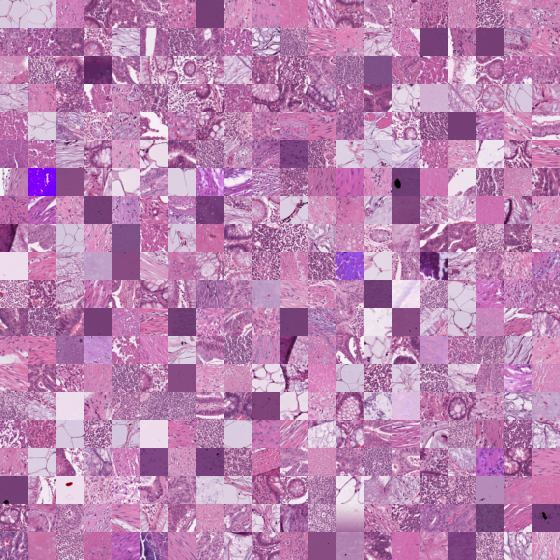

In [12]:
# montage
train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify

In [13]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=3),  #input size = 28, conv2d = 26
        nn.BatchNorm2d(16), 
        nn.ReLU())
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3),   # input size = 26, conv2d = 24, max_pool = 12
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(16, 64, kernel_size=3),  # input size = 12, conv2d = 10
        nn.BatchNorm2d(64),
        nn.ReLU())
        
        self.layer4 = nn.Sequential(
        nn.Conv2d(64,64, kernel_size=3),   # input size = 10, conv2d = 8
        nn.BatchNorm2d(64),
        nn.ReLU())
        
        self.layer5 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),  # input size = 8, conv2d = 8, maxpool2d  = 4
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(
        nn.Linear(64*4*4,128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model = Net(in_channels = n_channels, num_classes = n_classes)

# define loss function and optimizer
if task == 'multi-label, binary-class':
    criterion = nn.BCEWithLogitLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

## Next we can start to train and evaluate


In [14]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            
        loss.backward()
        optimizer.step()
        

100%|██████████| 704/704 [01:08<00:00, 10.34it/s]


In [15]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)
                
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            
        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating')
test('train')
test('test')

==> Evaluating
train  auc: 0.981  acc:0.820
test  auc: 0.939  acc:0.673
